In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [17]:
class LogisticRegressionNeuron:
    """
    A single neuron model for logistic regression.

    Attributes:
        learning_rate (float): The learning rate for weight updates.
        n_iters (int): The number of iterations for training.
        weights (ndarray): The weights of the neuron.
        bias (float): The bias term of the neuron.
    """
    def __init__(self, learning_rate=0.01, n_iters=1000):
        """
        Initializes the LogisticRegressionNeuron.

        Args:
            learning_rate (float, optional): The learning rate. Defaults to 0.01.
            n_iters (int, optional): The number of iterations. Defaults to 1000.
        """
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Trains the neuron on the given data using gradient descent.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).  Must be 0 or 1.
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Validate target values
        if not all(label in [0, 1] for label in y):
            raise ValueError("Target values must be 0 or 1 for Logistic Regression.")

        # Gradient Descent
        for _ in range(self.n_iters):
            # Calculate predictions (probabilities)
            linear_output = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_output)

            # Calculate the prediction error
            error = y_predicted - y

            # Calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X, threshold=0.5):
        """
        Predicts the class labels for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            threshold (float, optional): The probability threshold for classification. Defaults to 0.5.

        Returns:
            ndarray: The predicted class labels, shape (n_samples,).
        """
        # Compute probability scores using sigmoid
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted_proba = self._sigmoid(linear_output)

        # Convert probabilities to class labels
        y_predicted = np.where(y_predicted_proba >= threshold, 1, 0)
        return y_predicted
    
    def predict_proba(self, X):
        """
        Predicts the probabilities of the class labels for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted probabilities, shape (n_samples,).
        """
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted_proba = self._sigmoid(linear_output)
        return y_predicted_proba

    def score(self, X, y):
        """
        Calculates the accuracy of the model on the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The true labels, shape (n_samples,).

        Returns:
            float: The accuracy of the model.
        """
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y) / len(y)
        return accuracy

    def _sigmoid(self, x):
        """
        Computes the sigmoid function.

        Args:
            x (ndarray): The input values.

        Returns:
            ndarray: The sigmoid function applied to the input values.
        """
        return 1 / (1 + np.exp(-x))

In [19]:
df = pd.read_csv('cleaned_mlb_2022_full.csv')

# Define binary target: 1 if WAR >= 1, else 0 (A Wins Above Replacement (WAR) of 1 is the threshold I chose for a "meaningful contributor")
df['meaningful_contributor'] = (df['WAR'] >= 1).astype(int)

# Select relevant features
features = ['AVG', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'SB', 'BB%', 'K%']
X = df[features]
y = df['meaningful_contributor']

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [21]:
# Train model
model = LogisticRegressionNeuron(learning_rate=0.05, n_iters=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Accuracy
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


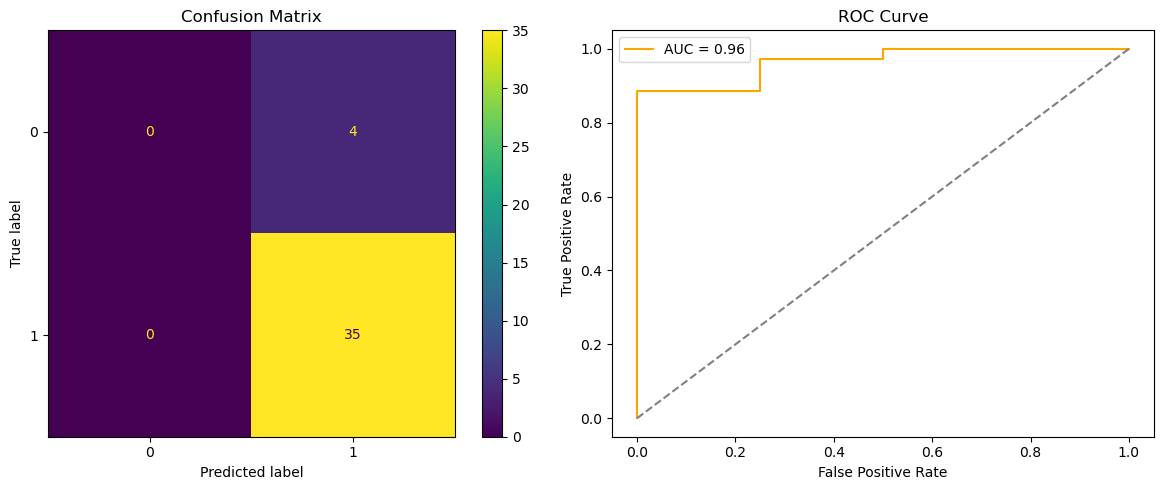

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# ROC metrics
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix plot
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0])
ax[0].set_title("Confusion Matrix")

# ROC curve plot
ax[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='orange')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.tight_layout()
plt.show()

The confusion matrix reveals how well the logistic regression model classifies players as meaningful contributors (WAR ≥ 1). The presence of both true positives and true negatives indicates the model is capturing distinguishing patterns in the data. Importantly, the model doesn't default to a single class: it's actively making positive and negative predictions, suggesting that it's learning a boundary based on real signal in the features like OBP, SLG, and K%. While some misclassifications remain, the distribution across cells shows that the model is engaging with both classes meaningfully.

The ROC curve further reinforces this. The curve bends away from the diagonal and the AUC (area under the curve) provides a summary metric of model discrimination (how well it separates contributors from non-contributors). A higher AUC indicates the model assigns higher probabilities to true contributors than to non-contributors, even if some thresholded classifications fall short. This probabilistic ranking is a core strength of logistic regression, offering more insight than just hard labels.

Both logistic regression and the perceptron update their weights based on misclassification, but their logic differs fundamentally. The perceptron uses a binary step function, it either updates or it doesn’t, based strictly on whether a prediction is wrong. Logistic regression, on the other hand, uses a sigmoid function to convert the input into a probability and updates its weights using a smooth gradient based on how confident or wrong the prediction is. This probabilistic foundation makes logistic regression better suited for datasets where classes aren't perfectly separable, like here, where “contributor” status depends on a blend of several nuanced features, and this isn't even weighing defensive or baserunning stats, which are both significant components of WAR.